In [33]:
import numpy as np
from numpy.random import randn
from numpy.random import randint
import os
import cv2
import pandas as pd
import gzip
from tensorflow.keras import backend as K
import tensorflow as tf 
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.initializers import RandomNormal
import random 
from tensorflow.keras.layers import Conv2D, Input, Dense, Activation, Reshape, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, Dropout, BatchNormalization
######################################## RANDOM SEED:
#random.seed(13)

#epsilon set according to BIGGAN https://arxiv.org/pdf/1809.11096.pdf

def _l2normalizer(v, epsilon=1e-4):
    return v / (K.sum(v**2)**0.5 + epsilon)


def power_iteration(W, u, rounds=1):
    '''
    Accroding the paper, we only need to do power iteration one time.
    '''
    _u = u

    for i in range(rounds):
        _v = _l2normalizer(K.dot(_u, W))
        _u = _l2normalizer(K.dot(_v, K.transpose(W)))

    W_sn = K.sum(K.dot(_u, W) * _v)
    return W_sn, _u, _v

"""
Convolution 2D with spectral normalization
"""
class SNConv2D(Conv2D):
    def __init__(self, filters, spectral_normalization=True, **kwargs):
        self.spectral_normalization = spectral_normalization
        super(SNConv2D, self).__init__(filters, **kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.

        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2D, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-1], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):

        outputs = K.conv2d(inputs,
                           self.compute_spectral_normal(training=training),
                           strides=self.strides, padding=self.padding,
                           data_format=self.data_format,
                           dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2D, self).compute_output_shape(input_shape)

"""
Transposed Convolution 2D with spectral normalization
"""
class SNConv2DTranspose(Conv2DTranspose):
    def __init__(self, spectral_normalization=True, **kwargs):
        self.spectral_normalization = spectral_normalization
        super(SNConv2DTranspose, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2DTranspose, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-2], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        out_pad_h = out_pad_w = None

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_output_length(
            height, kernel_h, self.padding, stride=stride_h)
        out_width = conv_utils.deconv_output_length(
            width, kernel_w, self.padding, stride=stride_w)
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        outputs = K.conv2d_transpose(
            inputs,
            self.compute_spectral_normal(training=training),
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format
        )

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2DTranspose, self).compute_output_shape(input_shape)

    



In [34]:
class PixelNormalization(Layer):
    def __init__(self, **kwargs):
        super(PixelNormalization, self).__init__(**kwargs)

    def call(self, inputs):
        # Calculate square pixel values
        values = inputs**2.0
        # Calculate the mean pixel values
        mean_values = tf.keras.backend.mean(values, axis=-1, keepdims=True)
        # Ensure the mean is not zero
        mean_values += 1.0e-8
        # Calculate the sqrt of the mean squared value (L2 norm)
        l2 = tf.keras.backend.sqrt(mean_values)
        # Normalize values by the l2 norm
        normalized = inputs / l2
        return normalized

    def compute_output_shape(self, input_shape):
        return input_shape
    

In [64]:
import tensorflow as tf

def hw_flatten(x):
    # Input shape x: [BATCH, HEIGHT, WIDTH, CHANNELS]
    # flat the feature volume across the width and height dimensions 
    x_shape = tf.shape(x)
    return tf.reshape(x, [x_shape[0], -1, x_shape[-1]]) # return [BATCH, W*H, CHANNELS]

"""
Self-attention layer with spectral normalization convolutions.
"""
class SelfAttention(Model):
    def __init__(self, number_of_filters, dtype=tf.float64, kernel_initializer="orthogonal"):
        super(SelfAttention, self).__init__()

        self.f = SNConv2D(number_of_filters//8, kernel_size=1,
                                         strides=1, padding='SAME', name="f_x",
                                         activation=None, dtype=dtype, kernel_initializer=kernel_initializer)

        self.g = SNConv2D(number_of_filters//8, kernel_size=1,
                                         strides=1, padding='SAME', name="g_x",
                                         activation=None, dtype=dtype, kernel_initializer=kernel_initializer)

        self.h = SNConv2D(number_of_filters, kernel_size=1,
                                         strides=1, padding='SAME', name="h_x",
                                         activation=None, dtype=dtype, kernel_initializer=kernel_initializer)

        self.gamma = tf.Variable(0., dtype=dtype, trainable=True, name="gamma")
        self.flatten = tf.keras.layers.Flatten()

    def call(self, x):

        f = self.f(x)
        g = self.g(x)
        h = self.h(x)

        f_flatten = hw_flatten(f)
        g_flatten = hw_flatten(g)
        h_flatten = hw_flatten(h)

        s = tf.matmul(g_flatten, f_flatten, transpose_b=True) # [B,N,C] * [B, N, C] = [B, N, N]

        b = tf.nn.softmax(s, axis=-1)
        o = tf.matmul(b, h_flatten)
        y = self.gamma * tf.reshape(o, tf.shape(x)) + x

        return y

In [65]:
class MinibatchStdev(Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    # perform the operation
    def call(self, inputs):
        # calculate the mean value for each pixel across channels
        mean = tf.keras.backend.mean(inputs, axis=0, keepdims=True)
        # calculate the squared differences between pixel values and mean
        squ_diffs = tf.keras.backend.square(inputs - mean)
        # calculate the average of the squared differences (variance)
        mean_sq_diff = tf.keras.backend.mean(squ_diffs, axis=0, keepdims=True)
        # add a small value to avoid a blow-up when we calculate stdev
        mean_sq_diff += 1e-8
        # square root of the variance (stdev)
        stdev = tf.keras.backend.sqrt(mean_sq_diff)
        # calculate the mean standard deviation across each pixel coord
        mean_pix = tf.keras.backend.mean(stdev, keepdims=True)
        # scale this up to be the size of one input feature map for each sample
        shape = tf.keras.backend.shape(inputs)
        output = tf.keras.backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
        # concatenate with the output
        combined = tf.keras.backend.concatenate([inputs, output], axis=-1)
        return combined

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        # create a copy of the input shape as a list
        input_shape = list(input_shape)
        # add one to the channel dimension (assume channels-last)
        input_shape[-1] += 1
        # convert list to a tuple
        return tuple(input_shape)

In [58]:
def get_attributes(filename, how_many, attributes_ind, dict_attributes, RandomListOfIntegers):
    # extract attribute names given the attribute indexes:
    list_attributes = []
    for attr in attributes_ind:
        list_attributes.append(dict_attributes[attr])
    # import the attributes you want:
    attributes = pd.read_csv(filename)[list_attributes]
    # convert to array
    attributes = np.array(attributes)
    # extract the attributes only of the number of images you want:
    attributes =  attributes[RandomListOfIntegers]
    
    return attributes

def load_images(dataset, images_directory, img_shape):
    X = []
    for i, myid in enumerate(dataset):
        image = load_img(images_directory + "/" + myid, target_size=img_shape[:2])
        image = (img_to_array(image) - 127.5) / 127.5 # from [0, 255] to [-1, 1]
        image = image[25:153, 45:173]
        image = cv2.resize(src=image, dsize=(64, 64))
        X.append(image)
    X = np.array(X)
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    #print('X.shape: ', X.shape, 'labels.shape: ', labels.shape, 'y.shape: ', y.shape)
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_attr, n_classes=2): # two calsses: 0 and 1
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim) # (64, 100)
    # generate labels
    labels = np.random.randint(n_classes, size=(n_samples, n_attr)) # HERE (n_samples, 40)
    return [z_input, labels]



# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples, n_attr, n_classes=2)
    #print('z_input: ', z_input.shape, 'labels_input: ', labels_input.shape)
    # predict outputs
    #concat = np.hstack((z_input, labels_input))
    concat = tf.concat([z_input, labels_input], axis=-1)
    images = generator.predict(concat)
    # create class labels
    y = np.zeros((n_samples, 1))
    #print('images: ', images.shape, 'labels_input: ', labels_input.shape, 'y: ', y.shape)
    return [images, labels_input], y


######### LOAD DATASET:
def load_dataset(how_many, ind_attributes, dict_attributes, images_directory = 'img_align_celeba_nozip', attr_file = 'list_attr_celeba.csv', img_shape = (178, 218, 3)):  
    RandomListOfIntegers = [random.randint(0,180000) for iter in range(how_many)] # 180000 is the training set size
    celeba_img = np.sort(os.listdir(images_directory))
    images_id = celeba_img[RandomListOfIntegers]
    images = load_images(images_id, images_directory, img_shape)
    attributes = get_attributes(attr_file, how_many, ind_attributes, dict_attributes, RandomListOfIntegers)
    attributes[attributes<=0] = 0
    dataset = [images, attributes]
    return dataset

######### LOAD FID DATASET:
def load_fid_dataset(how_many, ind_attributes, dict_attributes, images_directory = 'img_align_celeba_nozip', attr_file = 'list_attr_celeba.csv', img_shape = (178, 218, 3)):  
    # from 20k images I select "howmany" images for the fid. Note that "howmany" must be 10k
    RandomListOfIntegers = [random.randint(180000, 200000) for iter in range(how_many)]
    celeba_img = np.sort(os.listdir(images_directory))
    images_id = celeba_img[RandomListOfIntegers]
    images = load_images(images_id, images_directory, img_shape)
    attributes = get_attributes(attr_file, how_many, ind_attributes, dict_attributes, RandomListOfIntegers)
    attributes[attributes<=0] = 0
    fid_dataset = [images, attributes]
    return fid_dataset

######### LOAD GROUN TRUTH LABELS FOR FID:
def load_groundtruth_labels(how_many, ind_attributes, dict_attributes, attr_file = 'list_attr_celeba.csv'):  
    # the 200000 could also be the exact number of images of celeba
    RandomListOfIntegers = [random.randint(0, 200000) for iter in range(how_many)]
    attributes = get_attributes(attr_file, how_many, ind_attributes, dict_attributes, RandomListOfIntegers)
    attributes[attributes<=0] = 0
    return attributes

# plot of generated images
def plot_images(examples, n_test_images):
    # plot images
    for i in range(n_test_images):
        # define subplot
        plt.subplot(n_test_images/4, 4, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

In [66]:
def define_discriminator(n_attr, filters = 128, kernel_size = 3, in_shape=(64,64,3)): # HERE

    in_img = Input(shape=(in_shape))
    
    # 64 x 64 x FILTERS
    fe = SNConv2D(filters=filters, kernel_size=kernel_size, strides=(2,2), padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(in_img)
    fe = LeakyReLU(alpha=0.1)(fe)
    #fe = SelfAttention(filters, dtype=tf.float32)(fe)
    fe = MinibatchStdev()(fe)
    
    # 32 x 32 x FILTERS
    fe = SNConv2D(filters=filters * 2, kernel_size=kernel_size, strides=(2,2), padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
   
    # 16 x 16 x FILTERS
    fe = SNConv2D(filters=filters * 4, kernel_size=kernel_size, strides=(2,2), padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
   
    # 8 x 8 x FILTERS
    fe = SNConv2D(filters=filters * 8, kernel_size=kernel_size, strides=(2,2), padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
    
    # current: 4 x 4 x FILTERS
    fe = GlobalAveragePooling2D()(fe)
    
    # output about fake/real image:
    out1 = Dense(1, activation='sigmoid')(fe)
    # output about attributes:
    out2 = Dense(n_attr, activation='sigmoid')(fe) # what out2 is actually? Take into account problem of 0..9 mnist digit output
    
    # define model
    model = Model(in_img, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    # test these two lost, maybe hinge loss from alex should be used instead?
    model.compile(loss=["binary_crossentropy", "binary_crossentropy"], optimizer=opt, metrics=['accuracy'])
    return model



# define the standalone generator model
def define_generator(latent_dim, n_attr, filters=128, kernel_size=4):

    in_gen = Input(shape=(latent_dim + n_attr,))
    gen = Dense(4 * 4 * filters * 8)(in_gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, filters * 8))(gen)
    gen = PixelNormalization()(gen)
    
    
    # 4x4 -> 8x8
    gen = UpSampling2D()(gen)
    gen = SNConv2D(filters=filters * 4, kernel_size=kernel_size, strides=(1,1), padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(gen)
    gen = PixelNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 8x8 -> 16x16
    gen = UpSampling2D()(gen)
    gen = SNConv2D(filters=filters * 2, kernel_size=kernel_size, strides=(1,1), padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(gen)
    gen = PixelNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 16x16 -> 32x32
    gen = UpSampling2D()(gen)
    gen = SNConv2D(filters=filters, kernel_size=kernel_size, strides=(1,1), padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(gen)
    gen = PixelNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    #self attention layer
    #gen = SelfAttention(filters, dtype=tf.float32)(gen)
    
    # 32x32 -> 64x64
    gen = UpSampling2D()(gen)
    gen = SNConv2D(filters=filters // 2, kernel_size=kernel_size, strides=(1,1), padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(gen)
    gen = PixelNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 64 x 64 x FILTERS -> 64 x 64 x 3
    
    image = SNConv2D(filters=3, kernel_size=4, strides=(1, 1), activation='tanh', padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(gen)
    # define model
    model = Model(in_gen, image) # TODO: is in_gen ok? try with tf.concat...
    # Maybe the tf.concat should be done in the training when I do generator.train...
    return model



# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    img = g_model.output
    d_model.trainable = False
    valid, target_label = d_model(img)
    
    noise_plus_label = g_model.input
    model = Model(noise_plus_label, [valid, target_label])

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=["binary_crossentropy", "binary_crossentropy"], optimizer=opt)
    return model

In [67]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size, n_test_images):
    bat_per_epo = int(dataset[0].shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
           
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)   
           
            d_metrics1 = d_model.train_on_batch(X_real, [y_real, labels_real])##
           
            d_loss1 = d_metrics1[0]
           
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
          
            d_metrics2 = d_model.train_on_batch(X_fake, [y_fake, labels])
            
            d_loss2 = d_metrics2[0]
          
            [z_input, z_labels] = generate_latent_points(latent_dim, batch_size, n_attr, n_classes=2)
          
            y_gan = np.ones((batch_size, 1))
         
            #concat = np.hstack((z_input, z_labels))
            concat = tf.concat([z_input, z_labels], axis=-1)
            g_metrics = gan_model.train_on_batch(concat, [y_gan, z_labels])
            g_loss = g_metrics[0]
            
        # summarize loss on this batch
        print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        
        # save the generator model
        g_model.save('cgan2/cgan_generator' +str(i+j)+'.h5')
        model = load_model('cgan2/cgan_generator' +str(i+j)+'.h5',
                           custom_objects={'SNConv2DTranspose':SNConv2DTranspose, 'SNConv2D': SNConv2D, 'PixelNormalization': PixelNormalization, 'MinibatchStdev':MinibatchStdev, 'SelfAttention':SelfAttention})
        latent_points, labels = generate_latent_points(latent_dim, 100, n_attr)
        labels = load_groundtruth_labels(100, ind_attributes, dict_attributes)
        #concat = np.hstack((latent_points, labels))
        concat = tf.concat([latent_points, labels], axis=-1)
        # generate images
        X = g_model.predict(concat)
        # scale from [-1,1] to [0,1]
        X = (X + 1) / 2.0
        save_plot(X, 3)
        

In [68]:
######### ATTRIBUTE SELECTION:

# list the indexes of the attributes to be used to condition the generator:
dict_attributes = {1: '5_o_Clock_Shadow', 2: 'Arched_Eyebrows', 3: 'Attractive', 4: 'Bags_Under_Eyes', 
                   5: 'Bald', 6: 'Bangs', 7: 'Big_Lips', 8: 'Big_Nose', 9: 'Black_Hair', 10: 'Blond_Hair', 
                   11: 'Blurry', 12: 'Brown_Hair', 13: 'Bushy_Eyebrows', 14: 'Chubby', 15: 'Double_Chin', 
                   16: 'Eyeglasses', 17: 'Goatee', 18: 'Gray_Hair', 19: 'Heavy_Makeup', 20: 'High_Cheekbones', 
                   21: 'Male', 22: 'Mouth_Slightly_Open', 23: 'Mustache', 24: 'Narrow_Eyes', 25: 'No_Beard', 
                   26: 'Oval_Face', 27: 'Pale_Skin', 28: 'Pointy_Nose', 29: 'Receding_Hairline', 30: 'Rosy_Cheeks', 
                   31: 'Sideburns', 32: 'Smiling', 33: 'Straight_Hair', 34: 'Wavy_Hair', 35: 'Wearing_Earrings', 
                   36: 'Wearing_Hat', 37: 'Wearing_Lipstick', 38: 'Wearing_Necklace', 39: 'Wearing_Necktie', 40: 'Young'}

#ind_attributes = [9, 10, 32] # Black_Hair, Blond_Hair, Smiling

ind_attributes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
                 31, 32, 33, 34, 35, 36, 37, 38, 39, 40 ]
# use booleans to indicate respectively wrt the "ind_attributes" which attributes must be used to test the conditioning:
#ind_test_attributes = np.array([1, 1, 1])
ind_test_attributes = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1 , 1,
                               1, 1, 1, 1, 1, 1, 1, 1, 1 ,1,
                               1, 1, 1, 1, 1, 1, 1, 1, 1 ,1,
                               1, 1, 1, 1, 1, 1, 1, 1, 1 ,1])

In [69]:
############### PARAMETERS:

how_many = 200 ############################ number of images to use for training

# size of the latent space
latent_dim = 128


# divide dataset into this number of batches:
batch_size = 32 # number of images per batch

n_epochs = 100

n_test_images = 8 # number of images to save per each epoch, USE MULTIPLE OF 4


###########à FIXED PARAM: DON'T TOUCH THEM
# number of attributes per image:
n_attr = len(ind_attributes) 
n_classes=2 # just 2 possible value for each attribute

################# MODELS:
# create the discriminator
d_model = define_discriminator(n_attr)
#d_model.summary()

# create the generator
g_model = define_generator(latent_dim, n_attr)
#g_model.summary()

# create the gan
gan_model = define_gan(g_model, d_model)

dataset = load_dataset(how_many, ind_attributes, dict_attributes)

In [70]:
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size, n_test_images);

>1, 6/6, d1=1.333, d2=1.322 g=1.539


NotImplementedError: 

In [48]:
# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

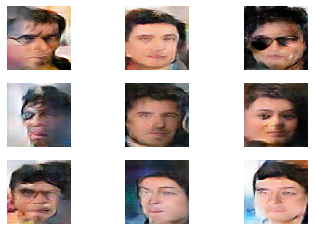

In [15]:
# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

model = load_model('cgan/cgan_generator_3attr_36epochs_50ktrainig_noembeddgin.h5',
                           custom_objects={'SNConv2DTranspose':SNConv2DTranspose, 'SNConv2D': SNConv2D})
latent_points, labels = generate_latent_points(latent_dim, 100, n_attr)
# specify labels
labels = np.zeros((latent_dim, n_attr))
#labels = load_groundtruth_labels(100, ind_attributes, dict_attributes)
labels[:, 0] = 1
# generate images
X = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
save_plot(X, 3)

In [ ]:
# define the standalone discriminator model
# A best practice involves using an embedding
# layer followed by a fully connected layer with a linear activation that scales the embedding to
# the size of the image before concatenating it in the model as an additional channel or feature
# map. A version of this recommendation was described in the 2015 paper titled Deep Generative
# Image Models using a Laplacian Pyramid of Adversarial Networks.
    
def define_discriminator(filters=64, kernel_size=3, in_shape=(64,64,3)):
    # input layer:
    in_image = Input(shape=in_shape)

    # 64 x 64 x FILTERS
    fe = SNConv2D(filters=filters, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(in_image) ##in_image
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    # 32 x 32 x FILTERS
    fe = SNConv2D(filters=filters * 2, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    # 16 x 16 x FILTERS
    fe = SNConv2D(filters=filters * 4, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    # 8 x 8 x FILTERS
    fe = SNConv2D(filters=filters * 8, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    
    # Current size: 4 x 4 x FILTERS 
    fe = GlobalAveragePooling2D()(fe)
    
    # output about fake/real image:
    out = Dense(1)(fe)
    
    # define model
    model = Model(in_image, out)
  
    return model

def define_classifier(filters=64, kernel_size=3, in_shape=(64,64,3)):
    # input layer:
    in_image = Input(shape=in_shape)

    # 64 x 64 x FILTERS
    fe = SNConv2D(filters=filters, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(in_image) ##in_image
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    # 32 x 32 x FILTERS
    fe = SNConv2D(filters=filters * 2, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    # 16 x 16 x FILTERS
    fe = SNConv2D(filters=filters * 4, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    # 8 x 8 x FILTERS
    fe = SNConv2D(filters=filters * 8, kernel_size=kernel_size, strides=(2,2), padding='same', spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.1)(fe)
    fe = Dropout(0.5)(fe)
    
    # Current size: 4 x 4 x FILTERS 
    fe = GlobalAveragePooling2D()(fe)
    
    # output about fake/real image:
    out = Dense(n_attr, activation='sigmoid')(fe)
    
    # define model
    model = Model(in_image, out)
  
    return model


# define the standalone generator model
def define_generator(latent_dim, n_attr, filters=64):

    in_label = Input(shape=(latent_dim + n_attr,)) 
    n_nodes = 4 * 4 * filters * 8
    gen = Dense(n_nodes)(in_label)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, filters * 8))(gen)
    gen = BatchNormalization()(gen)
    
    # 4x4 -> 8x8
    gen = UpSampling2D()(gen)
    gen = SNConv2D(filters=filters*4, kernel_size=4, strides=(1,1), padding='same', spectral_normalization=True)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 8x8 -> 16x16
    gen = UpSampling2D()(gen)
    gen = SNConv2D(filters=filters*2, kernel_size=4, strides=(1,1), padding='same', spectral_normalization=True)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 16x16 -> 32x32
    gen = UpSampling2D()(gen)
    gen = SNConv2D(filters=filters, kernel_size=4, strides=(1,1), padding='same', spectral_normalization=True)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 32x32 -> 64x64
    gen = UpSampling2D()(gen)
    gen = SNConv2D(filters=filters // 2, kernel_size=4, strides=(1,1), padding='same', spectral_normalization=True)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # output
    out_layer = SNConv2D(filters=3, kernel_size=4, activation='tanh', padding='same', spectral_normalization=True)(gen)
    # define model
    model = Model(in_label, out_layer)
    return model


